In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T

import numpy as np
import time
from typing import Tuple


## 1. Image Classification Task & Dataset

**Task**: Given an input image `x`, predict a label `y` from a fixed set of classes.

**Challenges**:
- Viewpoint variation
- Illumination changes
- Background clutter
- Occlusion
- Deformation
- Intraclass variation

In practice, large datasets (e.g., ImageNet, CIFAR-10) play a crucial role in
training powerful image classifiers.

In this notebook we'll use **CIFAR-10**:
- 60,000 color images of size 32×32
- 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
- 50,000 for training, 10,000 for test


In [3]:
transform = T.Compose([
    T.ToTensor(),  # [0, 1]
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

num_train = len(train_dataset)
num_val = 5000
num_train_split = num_train - num_val

train_split, val_split = random_split(train_dataset, [num_train_split, num_val])

train_loader = DataLoader(train_split, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_split, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

classes = train_dataset.classes
len(train_dataset), len(val_split), len(test_dataset), classes


100%|██████████| 170M/170M [00:38<00:00, 4.48MB/s] 


(50000,
 5000,
 10000,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

## 2. Nearest Neighbor and k-Nearest Neighbor

### 2.1 1-Nearest Neighbor (1-NN)

**Training**:
- Simply memorize all training examples and their labels.

**Prediction for a test example** `x_test`:
1. Compute distance between `x_test` and each training sample `x_i`.
2. Find the nearest training example.
3. Output its label.

Time complexity:
- Training: O(1)
- Prediction: O(N_train × N_test) — very slow when N is large.

### 2.2 Distance Metrics

For vectors `x, y ∈ R^D`:

- L1 (Manhattan):  $$d_1(x, y) = \sum_i |x_i - y_i| $$
- L2 (Euclidean):  $$d_2(x, y) = \sqrt{\sum_i (x_i - y_i)^2} $$
- General Lp:      $$d_p(x, y) = (\sum_i |x_i - y_i|^p)^{1/p} $$

When $$p → ∞$$, we get **Chebyshev distance**.

### 2.3 k-Nearest Neighbor (k-NN)

- Instead of just 1 nearest neighbor, choose the `k` closest training samples.
- Predict by **majority vote** over these `k` labels.

`k` and the choice of distance metric are **hyperparameters**.


In [4]:
# To keep it simple & fast, we only use a subset of training data for KNN.
subset_size = 5000
indices = torch.randperm(num_train_split)[:subset_size]
knn_subset = torch.utils.data.Subset(train_split, indices)

# Flatten images to vectors
def dataset_to_numpy(dataset):
    X_list, y_list = [], []
    for img, label in dataset:
        X_list.append(img.view(-1).numpy())
        y_list.append(label)
    X = np.stack(X_list, axis=0)  # [N, D]
    y = np.array(y_list)          # [N]
    return X, y

X_train_knn, y_train_knn = dataset_to_numpy(knn_subset)

# Also prepare a small validation subset for KNN evaluation
val_subset_size = 1000
val_indices = torch.randperm(len(val_split))[:val_subset_size]
val_subset = torch.utils.data.Subset(val_split, val_indices)
X_val_knn, y_val_knn = dataset_to_numpy(val_subset)

X_train_knn.shape, X_val_knn.shape


((5000, 3072), (1000, 3072))

In [5]:
def l2_distance_batch(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Compute pairwise L2 distances between two sets of vectors:
    X: [N, D]
    Y: [M, D]
    returns: [N, M]
    """
    # (x - y)^2 = x^2 + y^2 - 2 x·y
    X_norm = np.sum(X ** 2, axis=1, keepdims=True)     # [N, 1]
    Y_norm = np.sum(Y ** 2, axis=1, keepdims=True).T   # [1, M]
    cross = X @ Y.T                                    # [N, M]
    dists = np.sqrt(X_norm + Y_norm - 2 * cross + 1e-8)
    return dists


def knn_predict(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    k: int = 1,
) -> np.ndarray:
    """
    k-NN classifier.
    X_train: [N_train, D]
    y_train: [N_train]
    X_test: [N_test, D]
    """
    dists = l2_distance_batch(X_test, X_train)  # [N_test, N_train]
    # indices of k nearest neighbors
    knn_idx = np.argpartition(dists, k, axis=1)[:, :k]  # [N_test, k]
    knn_labels = y_train[knn_idx]                       # [N_test, k]
    # majority vote
    preds = []
    for labels in knn_labels:
        values, counts = np.unique(labels, return_counts=True)
        preds.append(values[np.argmax(counts)])
    return np.array(preds)


这段代码实现的是k-NN算法中的**多数投票（majority vote）**过程。让我用具体例子来说明：

## 多数投票过程

假设我们有一个测试样本，它的k=5个最近邻的标签如下：



In [ ]:
# 假设某个测试样本的5个最近邻标签
labels = np.array([2, 1, 2, 0, 2])  # 来自knn_labels中的一行

# 执行多数投票
values, counts = np.unique(labels, return_counts=True)
print("values:", values)   # [0, 1, 2] - 出现的唯一标签
print("counts:", counts)   # [1, 1, 3] - 对应的出现次数

# 找出现次数最多的标签
most_frequent_idx = np.argmax(counts)  # 2 (counts中最大值的索引)
prediction = values[most_frequent_idx]  # values[2] = 2
print("prediction:", prediction)  # 2



## 完整流程示例



In [ ]:
# 假设我们有3个测试样本，k=3
knn_labels = np.array([
    [1, 1, 0],  # 测试样本0的3个近邻标签
    [2, 1, 2],  # 测试样本1的3个近邻标签  
    [0, 0, 1],  # 测试样本2的3个近邻标签
])

preds = []
for labels in knn_labels:
    print(f"处理标签: {labels}")
    values, counts = np.unique(labels, return_counts=True)
    print(f"  唯一值: {values}, 计数: {counts}")
    
    most_frequent = values[np.argmax(counts)]
    print(f"  预测结果: {most_frequent}")
    preds.append(most_frequent)
    print()

print("最终预测:", np.array(preds))



**输出：**


In [ ]:
处理标签: [1 1 0]
  唯一值: [0 1], 计数: [1 2]
  预测结果: 1

处理标签: [2 1 2]  
  唯一值: [1 2], 计数: [1 2]
  预测结果: 2

处理标签: [0 0 1]
  唯一值: [0 1], 计数: [2 1]  
  预测结果: 0

最终预测: [1 2 0]



## 核心思想

1. **统计频次**：`np.unique()` 统计每个标签的出现次数
2. **找最大值**：`np.argmax(counts)` 找出现最多的标签的索引
3. **返回预测**：`values[argmax_idx]` 得到最终预测标签

这样，每个测试样本的预测就是其k个最近邻中**出现次数最多的类别**，这就是k-NN的多数投票机制。

这行代码是在实现 **k-NN (k近邻)** 算法中的关键步骤：**找到每个测试样本的 k 个最近邻**。



In [ ]:
knn_idx = np.argpartition(dists, k, axis=1)[:, :k]  # [N_test, k]



**逐步解析：**

1. **`dists`**: 形状为 `[N_test, N_train]` 的距离矩阵
   - `dists[i, j]` = 第i个测试样本到第j个训练样本的距离

2. **`np.argpartition(dists, k, axis=1)`**: 
   - 对每一行（每个测试样本）进行部分排序
   - 将最小的 k 个元素放到前 k 个位置
   - 返回**索引**而不是值
   - **不完全排序**，只保证前k个是最小的

3. **`[:, :k]`**: 只取前 k 列，得到每个测试样本的 k 个最近邻的索引

**举例说明：**


In [ ]:
# 假设有3个测试样本，5个训练样本，k=2
dists = np.array([
    [3.1, 1.5, 4.2, 2.0, 3.8],  # 测试样本0到各训练样本的距离
    [2.1, 3.5, 1.2, 4.0, 1.8],  # 测试样本1到各训练样本的距离  
    [1.9, 2.5, 3.1, 1.1, 2.8],  # 测试样本2到各训练样本的距离
])

knn_idx = np.argpartition(dists, 2, axis=1)[:, :2]
# 结果可能是：
# [[1, 3],  # 测试样本0的2个最近邻：训练样本1和3
#  [2, 4],  # 测试样本1的2个最近邻：训练样本2和4  
#  [3, 0]]  # 测试样本2的2个最近邻：训练样本3和0



这样就得到了每个测试样本对应的 k 个最近邻训练样本的**索引**，用于后续的多数投票预测。

In [6]:
start = time.time()
y_val_pred_k1 = knn_predict(X_train_knn, y_train_knn, X_val_knn, k=1)
acc_k1 = (y_val_pred_k1 == y_val_knn).mean()
end = time.time()

print(f"k=1, val accuracy={acc_k1:.4f}, time={end-start:.2f}s")


k=1, val accuracy=0.2620, time=0.31s


## 3. Hyperparameters, Validation Set, and Cross-Validation

In k-NN, important **hyperparameters** include:
- `k`: number of neighbors
- distance metric (L1, L2, etc.)

We don't know the best choice a priori.
Instead we:
1. Split data into **train / validation / test**.
2. Use **train** to fit parameters (here: just store samples).
3. Use **validation** to choose hyperparameters.
4. Finally evaluate the chosen model once on **test**.

### Cross-validation (CV)

For smaller datasets:
- Split training data into K folds.
- For each hyperparameter setting:
  - Train on K-1 folds
  - Validate on the remaining fold
  - Average performance across folds

For large deep learning datasets, CV is often too expensive,
so we typically:
- Use a single train/val split
- Possibly repeat experiments if needed


In [7]:
def evaluate_knn_for_k_list(ks):
    results = {}
    for k in ks:
        start = time.time()
        y_val_pred = knn_predict(X_train_knn, y_train_knn, X_val_knn, k=k)
        acc = (y_val_pred == y_val_knn).mean()
        end = time.time()
        print(f"k={k}, val accuracy={acc:.4f}, time={end-start:.2f}s")
        results[k] = acc
    return results

k_list = [1, 3, 5, 7, 9]
knn_results = evaluate_knn_for_k_list(k_list)
knn_results


k=1, val accuracy=0.2620, time=0.21s
k=3, val accuracy=0.2460, time=0.08s
k=5, val accuracy=0.2510, time=0.11s
k=7, val accuracy=0.2660, time=0.09s
k=9, val accuracy=0.2740, time=0.07s


{1: np.float64(0.262),
 3: np.float64(0.246),
 5: np.float64(0.251),
 7: np.float64(0.266),
 9: np.float64(0.274)}

你观察得很仔细！但在这个代码中，**验证集实际上是固定的**，每次k-NN实验都使用相同的验证集。

让我分析一下代码：



In [ ]:
# 在函数外部，验证集已经固定创建
val_subset_size = 1000
val_indices = torch.randperm(len(val_split))[:val_subset_size]  # 固定的随机索引
val_subset = torch.utils.data.Subset(val_split, val_indices)
X_val_knn, y_val_knn = dataset_to_numpy(val_subset)  # 固定的验证集

def evaluate_knn_for_k_list(ks):
    results = {}
    for k in ks:
        # 每次都使用相同的 X_val_knn, y_val_knn
        y_val_pred = knn_predict(X_train_knn, y_train_knn, X_val_knn, k=k)
        acc = (y_val_pred == y_val_knn).mean()
        results[k] = acc
    return results



## 这样做是正确的！

**原因：**
1. **超参数选择**：我们要比较不同k值的性能，必须在**相同的验证集**上测试
2. **公平比较**：如果每次k都用不同验证集，就无法知道性能差异是由于k的不同还是数据的不同
3. **标准做法**：在机器学习中，超参数调优时验证集是固定的

## 如果要使用交叉验证

如果你想要更robust的评估，应该使用交叉验证：



In [ ]:
def evaluate_knn_cv(k, n_folds=5):
    # 将训练数据分成n_folds份
    fold_size = len(X_train_knn) // n_folds
    accuracies = []
    
    for fold in range(n_folds):
        # 每一折作为验证集
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        
        val_X = X_train_knn[val_start:val_end]
        val_y = y_train_knn[val_start:val_end]
        
        train_X = np.concatenate([X_train_knn[:val_start], X_train_knn[val_end:]])
        train_y = np.concatenate([y_train_knn[:val_start], y_train_knn[val_end:]])
        
        pred = knn_predict(train_X, train_y, val_X, k)
        acc = (pred == val_y).mean()
        accuracies.append(acc)
    
    return np.mean(accuracies)



但对于大数据集，通常使用单一的train/val/test分割就足够了。

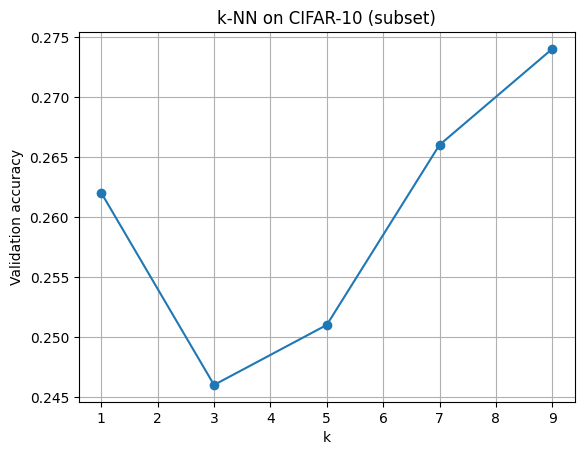

In [8]:
import matplotlib.pyplot as plt

ks = sorted(knn_results.keys())
accs = [knn_results[k] for k in ks]

plt.figure()
plt.plot(ks, accs, marker="o")
plt.xlabel("k")
plt.ylabel("Validation accuracy")
plt.title("k-NN on CIFAR-10 (subset)")
plt.grid(True)
plt.show()


## 4. Limitations of k-NN

**Empirical issues on image classification**:
- High error rate
- Very slow prediction time for large datasets
- Needs to store all training examples

Main reasons:
1. Distance in raw pixel space is not semantically meaningful
   - Two images that look very different can still have small pixel-wise distance
   - Two very similar images can have large pixel-wise distance under some noise
2. Curse of dimensionality
   - In high dimensions, distances become less informative
   - Computational complexity is high

These motivate **parametric** models, where we learn a small number of
parameters (e.g., weights of a linear classifier) to summarize the data.


## 5. Linear Classifier

We flatten the image `x ∈ R^D` and want to predict one of `C` classes.

We introduce parameters:
- Weight matrix $$ W ∈ R^{C × D} $$
- Bias vector $$ b ∈ R^C $$

The **score vector** is:
$$
s = f(x; W, b) = Wx + b  \quad (s ∈ R^C)
$$

Interpretations:
- Algebraic: a linear transformation followed by a translation
- Visual: each row of W can be seen as a "template" for a class
- Geometric: each class defines a hyperplane; classification partitions
  the data space into regions


In [9]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim: int, num_classes: int):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # x: [B, 3, 32, 32]
        x = x.view(x.size(0), -1)  # flatten
        scores = self.fc(x)        # [B, C]
        return scores

input_dim = 3 * 32 * 32
num_classes = 10
model = LinearClassifier(input_dim, num_classes)
model


LinearClassifier(
  (fc): Linear(in_features=3072, out_features=10, bias=True)
)

## 6. SVM (Hinge) Loss for Linear Classifier

For an input x with true label y (0 ≤ y < C), let scores be:
$$
s = f(x; W, b) ∈ R^C
$$

Multiclass SVM / hinge loss:
$$
L_i = \sum_{j ≠ y} \max(0,\; s_j - s_y + \Delta),
$$
where typically $ \Delta = 1 $.

Dataset loss is the average:
$$
L = \frac{1}{N} \sum_{i=1}^N L_i.
$$

Intuition:
$$
L_i = \sum_{j ≠ y} \max(0,\; s_j - s_y + \Delta),
$$
where typically $\Delta = 1$.

Dataset loss is the average:
$$
L = \frac{1}{N} \sum_{i=1}^N L_i.
$$


Intuition:
- We want the **correct class score** $s_y$ to be larger than every
  incorrect score $s_j$ by at least a margin of 1.

Questions to think about:
- What is the minimum and maximum possible value of $L_i$?
- What happens at initialization when all scores are close to zero?


## 6. 线性分类器的SVM（铰链）损失

对于输入 x 和真实标签 y（0 ≤ y < C），设分数为：
$$
s = f(x; W, b) ∈ R^C
$$

多类别SVM/铰链损失：
$$
L_i = \sum_{j ≠ y} \max(0,\; s_j - s_y + \Delta),
$$
其中通常 $\Delta = 1$。

数据集损失是平均值：
$$
L = \frac{1}{N} \sum_{i=1}^N L_i.
$$

**直观理解：**
- 我们希望**正确类别的分数** $s_y$ 比每个错误类别的分数 $s_j$ 至少大 1 个边距。

**思考问题：**
- $L_i$ 的最小值和最大值可能是多少？
- 当初始化时所有分数都接近零时会发生什么？

**详细解释：**

1. **损失函数的含义**：
   - 对于每个样本，我们计算正确类别分数与所有错误类别分数的差异
   - 如果正确类别分数足够高（比错误类别分数高1以上），损失为0
   - 否则，损失随着分数差异的减小而增加

2. **边距的作用**：
   - $\Delta = 1$ 定义了一个"安全边距"
   - 不仅要求正确类别分数最高，还要求至少高出1个单位

3. **实际应用**：
   - 这种损失函数鼓励模型产生明确的预测
   - 有助于提高分类的鲁棒性

In [10]:
def multiclass_hinge_loss(scores: torch.Tensor, y: torch.Tensor, margin: float = 1.0):
    """
    scores: [B, C]
    y: [B]  (ground truth labels, 0..C-1)
    """
    B, C = scores.shape
    # correct class scores: [B, 1]
    correct_scores = scores[torch.arange(B), y].unsqueeze(1)
    # compute margins: [B, C]
    margins = scores - correct_scores + margin
    margins[torch.arange(B), y] = 0.0  # ignore correct class
    # hinge
    loss = torch.clamp(margins, min=0.0)
    return loss.mean()


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

svm_model = LinearClassifier(input_dim, num_classes).to(device)
optimizer = torch.optim.SGD(svm_model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 3  # for demo

def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            scores = model(X)
            preds = scores.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for epoch in range(num_epochs):
    svm_model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        scores = svm_model(X)
        loss = multiclass_hinge_loss(scores, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_acc = evaluate_accuracy(svm_model, val_loader)
    print(f"[SVM] epoch {epoch+1}/{num_epochs}, train loss={train_loss:.4f}, val acc={val_acc:.4f}")


Using device: cpu
[SVM] epoch 1/3, train loss=0.6026, val acc=0.3320
[SVM] epoch 2/3, train loss=0.5109, val acc=0.3472
[SVM] epoch 3/3, train loss=0.4903, val acc=0.3508


## 7. Softmax Classifier and Cross-Entropy Loss

Linear classifier outputs raw scores $s ∈ R^C$.
We convert scores to probabilities via **softmax**:

$$
q_k = P(Y = k | X = x) =
\frac{\exp(s_k)}{\sum_{j} \exp(s_j)}.
$$

Given true label y, the loss is the **negative log-likelihood**:

$$
L_i = -\log q_{y}
    = -\log \frac{\exp(s_y)}{\sum_j \exp(s_j)}.
$$

This is exactly the **cross-entropy** between:
- The one-hot ground-truth distribution p(x)
- The predicted distribution q(x)

At initialization when all scores are equal:
$$
q_k = \frac{1}{C}, \quad
L_i = -\log\frac{1}{C} = \log C.
$$

For C=10, this is approximately 2.3.


In [13]:
def manual_cross_entropy_loss(scores: torch.Tensor, y: torch.Tensor):
    """
    scores: [B, C] (logits)
    y: [B]
    """
    # log-softmax
    log_probs = F.log_softmax(scores, dim=1)  # [B, C]
    print("log_probs:", log_probs)
    print("y:", y)
    # pick the log-prob of correct class
    loss = -log_probs[torch.arange(scores.size(0)), y]
    return loss.mean()

# Compare with built-in CrossEntropyLoss
ce_builtin = nn.CrossEntropyLoss()
scores_demo = torch.tensor([[1.0, 2.0, 0.5],
                            [0.1, 0.2, 0.3]])
y_demo = torch.tensor([1, 2])

loss_manual = manual_cross_entropy_loss(scores_demo, y_demo)
loss_builtin = ce_builtin(scores_demo, y_demo)
loss_manual, loss_builtin


log_probs: tensor([[-1.4644, -0.4644, -1.9644],
        [-1.2019, -1.1019, -1.0019]])
y: tensor([1, 2])


(tensor(0.7332), tensor(0.7332))

这是一个很好的问题！让我详细解释这行代码是如何工作的：



In [ ]:
loss = -log_probs[torch.arange(scores.size(0)), y]



## 核心机制：高级索引（Advanced Indexing）

这里使用了PyTorch的**高级索引**功能来选择正确类别的概率。

### 逐步分解：



In [ ]:
# 假设我们有一个具体的例子
scores = torch.tensor([[1.0, 2.0, 0.5],    # 样本0的分数 [类别0, 类别1, 类别2]
                      [0.1, 0.2, 0.3]])    # 样本1的分数

y = torch.tensor([1, 2])  # 样本0的真实标签是1，样本1的真实标签是2

# log_softmax后得到对数概率
log_probs = F.log_softmax(scores, dim=1)
# log_probs = [[-1.31, -0.31, -1.81],    # 样本0的对数概率
#              [-1.20, -1.10, -1.00]]    # 样本1的对数概率

# 创建行索引
batch_indices = torch.arange(scores.size(0))  # [0, 1]

# 高级索引选择
selected = log_probs[batch_indices, y]
# 等价于：log_probs[[0, 1], [1, 2]]
# 选择：log_probs[0, 1] 和 log_probs[1, 2]
# 结果：[-0.31, -1.00]



### 可视化理解：



In [ ]:
# log_probs矩阵：
#       类别0   类别1   类别2
# 样本0  -1.31   -0.31   -1.81   ← y[0]=1，选择log_probs[0,1]=-0.31
# 样本1  -1.20   -1.10   -1.00   ← y[1]=2，选择log_probs[1,2]=-1.00

print("batch_indices:", torch.arange(scores.size(0)))  # [0, 1]
print("y:", y)                                          # [1, 2]
print("selected:", log_probs[torch.arange(scores.size(0)), y])  # [-0.31, -1.00]



### 等价的其他写法：



In [ ]:
# 方法1：循环（效率低）
selected_loop = []
for i in range(len(y)):
    selected_loop.append(log_probs[i, y[i]])

# 方法2：使用gather函数
selected_gather = log_probs.gather(1, y.unsqueeze(1)).squeeze(1)

# 方法3：使用高级索引（推荐）
selected_advanced = log_probs[torch.arange(len(y)), y]



## 为什么这样写有效？

1. **`torch.arange(scores.size(0))`** 生成行索引 `[0, 1, 2, ..., B-1]`
2. **`y`** 提供列索引，表示每个样本的真实标签
3. **高级索引** `log_probs[行索引, 列索引]` 同时选择多个元素
4. 结果是每个样本对应其真实类别的对数概率

这种写法既简洁又高效，是PyTorch中处理这类问题的标准做法！

In [14]:
softmax_model = LinearClassifier(input_dim, num_classes).to(device)
optimizer = torch.optim.SGD(softmax_model.parameters(), lr=1e-1, momentum=0.9)
criterion = nn.CrossEntropyLoss()

num_epochs = 5  # small demo

for epoch in range(num_epochs):
    softmax_model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        scores = softmax_model(X)
        loss = criterion(scores, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_acc = evaluate_accuracy(softmax_model, val_loader)
    print(f"[Softmax] epoch {epoch+1}/{num_epochs}, train loss={train_loss:.4f}, val acc={val_acc:.4f}")

test_acc = evaluate_accuracy(softmax_model, test_loader)
print(f"Test accuracy (Softmax linear classifier): {test_acc:.4f}")


[Softmax] epoch 1/5, train loss=23.7025, val acc=0.2910
[Softmax] epoch 2/5, train loss=17.9099, val acc=0.2956
[Softmax] epoch 3/5, train loss=18.7217, val acc=0.3046
[Softmax] epoch 4/5, train loss=18.1426, val acc=0.2236
[Softmax] epoch 5/5, train loss=17.4512, val acc=0.2744
Test accuracy (Softmax linear classifier): 0.2629


In [15]:
def svm_loss_single(scores, y, margin=1.0):
    scores = torch.tensor(scores).unsqueeze(0)  # [1, C]
    y = torch.tensor([y])
    return multiclass_hinge_loss(scores, y, margin=margin).item()

def ce_loss_single(scores, y):
    scores = torch.tensor(scores).unsqueeze(0)
    y = torch.tensor([y])
    return manual_cross_entropy_loss(scores, y).item()

examples = [
    ("case1", [10, -2, 3], 0),
    ("case2", [10, 9, 9], 0),
    ("case3", [10, -100, -100], 0),
]

for name, scores, y in examples:
    svm_l = svm_loss_single(scores, y)
    ce_l = ce_loss_single(scores, y)
    print(name, scores)
    print(f"  SVM loss = {svm_l:.4f}")
    print(f"  CE  loss = {ce_l:.4f}")


NotImplementedError: "log_softmax_lastdim_kernel_impl" not implemented for 'Long'

## 9. Comparing SVM (Hinge) and Softmax (Cross-Entropy)

- **SVM / Hinge loss**:
  - Encourages a margin between correct and incorrect class scores.
  - Once the margin is satisfied, further increasing \(s_y - s_j\) does not reduce loss.
  - "Margin-based" — becomes "happy" when margins are satisfied.

- **Softmax / CE loss**:
  - Treats scores as unnormalized log-probabilities.
  - Always pushes for higher probability on the correct class,
    and lower probabilities on incorrect classes.
  - Never fully happy — there is always room to improve probabilities.

In practice:
- Both are reasonable for linear classifiers.
- For modern deep networks, **Cross-Entropy loss** is more commonly used.
